https://docs.google.com/presentation/d/1ji4JgDxm4zp_AnsC_NIpZkusBhD5DtUV4iU9gj9i_Z4/edit#slide=id.g6021744a7c_1_163

# Maps

In [67]:
def load_processed_images(data_maps, 
    return_names=[(1,4,'cbmap'), (1,4,'psmap')],
    rotate_TM2=False):
    '''
    get the images processed from image_reduction
    
    valid map_names:
    
    'rawmap': line fit w/o linearization [ADU/fr]
    'rawmask': DC inst mask * negative pixel mask * ts mask
    'DCmap': DC map [ADU/fr]
    'DCsubmap': linearized map - DC template [ADU/fr]
    'FFpix': FF from stacking off fields. It takes NaNs values at pix w/o FF info
    'FFsm': FFpix smoothed with 3pix Gaussian kernel to fill in NaNs
    'FF': final FF estimator. FFpix with NaNs filled with FFsm 
    'mask_inst': final instrument mask. rawmask * crmask * sigma clip mask
    'strmask': source mask (m < 20)
    'strnum': source num
    'map': final image after FF corr [ADU/fr]
    'srcmap': source map from PanSTARRS & 2MASS bright sources [nW/m2/sr]
    'cbmap': mean sub 'map' with mask_inst * strmask [nW/m2/sr]
    'psmap': mean sub 'srcmap' with mask_inst * strmask [nW/m2/sr]
    
    Input:
    =======
    data_maps: data dict obtained by --
        from reduction import *
        data_maps = {1: image_reduction(1), 2: image_reduction(2)}

    return_names: list of items (inst, ifield, map_name)
    rotate_TM2: if True, rotate TM2 90 deg 
        s.t. it's aligned with TM1 for visualization

    Ouput:
    =======
    return_maps: list of map of the input return_names
    
    '''

    return_maps = []
    for inst,ifield,name in return_names:
        
        if name == 'cbmap':
            cf = cal_factor_dict['apf2nWpm2psr'][inst][ifield]
            mapi = data_maps[inst].stackmapdat[ifield]['map'].copy()
            mask_inst = data_maps[inst].stackmapdat[ifield]['mask_inst'].copy()
            strmask = data_maps[inst].stackmapdat[ifield]['strmask'].copy()
            mapi = cf * (mapi - np.mean(mapi[mask_inst*strmask==1]))
            
        elif name == 'psmap':
            mapi = data_maps[inst].stackmapdat[ifield]['srcmap'].copy()
            mask_inst = data_maps[inst].stackmapdat[ifield]['mask_inst'].copy()
            strmask = data_maps[inst].stackmapdat[ifield]['strmask'].copy()
            mapi = mapi - np.mean(mapi[mask_inst*strmask==1])

        elif name == 'DCmap':
            mapi = data_maps[inst].DCtemplate
            
        else:
            mapi = data_maps[inst].stackmapdat[ifield][name].copy() 
        
        if rotate_TM2 and inst==2:
            mapi = np.rot90(mapi, k=3)

        return_maps.append(mapi)

    return return_maps

In [1]:
from reduction import *
from utils import *

data_maps = {1: image_reduction(1), 2: image_reduction(2)}

In [88]:
rawmask1,rawmask2\
= load_processed_images(data_maps, [(1,ifield,'DCmap'),(2,ifield,'DCmap')],
                       rotate_TM2=True)


In [92]:
np.mean(rawmask1[rawmask1!=0])*cal_factor_dict['apf2eps'][1],np.mean(rawmask2[rawmask2!=0])*cal_factor_dict['apf2eps'][2]

(0.13335979602440776, 0.10371800046046417)

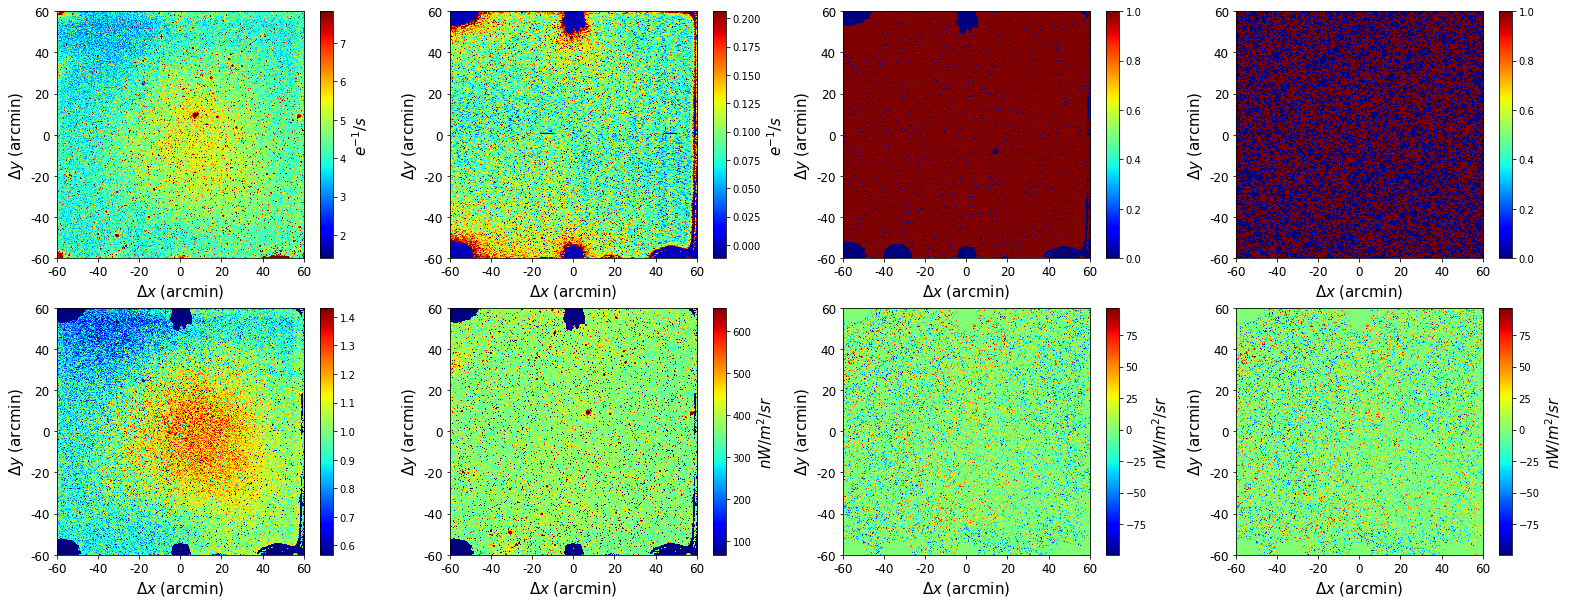

In [70]:
pixticks = np.linspace(0,1023,7)
pixtick_labels = ['-60', '-40', '-20', '0', '20', '40', '60']

for ifield in [4,5,6,7,8]:
    for inst in [1,2]:
        apf2eps = cal_factor_dict['apf2eps'][inst]
        apf2nWpm2psr = cal_factor_dict['apf2nWpm2psr'][inst][ifield]
        rawmap, DCmap, mask_inst, mapin, cbmap, strmask, FF\
        = load_processed_images(data_maps, [(inst,ifield,'rawmap'),
                                            (inst,ifield,'DCmap'),
                                           (inst,ifield,'mask_inst'),
                                           (inst,ifield,'map'),
                                           (inst,ifield,'cbmap'),
                                           (inst,ifield,'strmask'),
                                           (inst,ifield,'FF')],
                               rotate_TM2=True)
        plt.close()
        fig, ax = plt.subplots(2, 4, figsize = (27,10))
        axi = ax[0][0]
        p = imageclip(rawmap*apf2eps, ax=axi, return_objects=True)
        p['cbar'].ax.set_ylabel('$e^{-1}/s$', rotation=90, fontsize=15)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
        
        axi = ax[0][1]
        p = imageclip(DCmap*apf2eps, ax=axi, return_objects=True)
        p['cbar'].ax.set_ylabel('$e^{-1}/s$', rotation=90, fontsize=15)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

        axi = ax[0][2]
        p = imageclip(mask_inst, ax=axi, return_objects=True)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
        
        axi = ax[0][3]
        p = imageclip(strmask, ax=axi, return_objects=True)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

        axi = ax[1][0]
        p = imageclip(FF, ax=axi, return_objects=True)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
        
        axi = ax[1][2]
        p = imageclip(cbmap*mask_inst*strmask, ax=axi, return_objects=True)
        p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

        axi = ax[1][3]
        filtmap = image_poly_filter(cbmap, strmask*mask_inst, degree=2)
        p = imageclip(filtmap*mask_inst*strmask, ax=axi, 
                      vmin=p['vmin'], vmax=p['vmax'],return_objects=True)
        p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

        axi = ax[1][1]
        meanmap = np.mean(mapin[mask_inst*strmask==1])*apf2nWpm2psr
        p = imageclip(mapin*apf2nWpm2psr, ax=axi,
                      vmin=3*p['vmin']+meanmap, vmax=3*p['vmax']+meanmap,return_objects=True)
        p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

        plt.savefig('plots/paperfig/maps_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
                    dpi = 200, bbox_inches='tight')

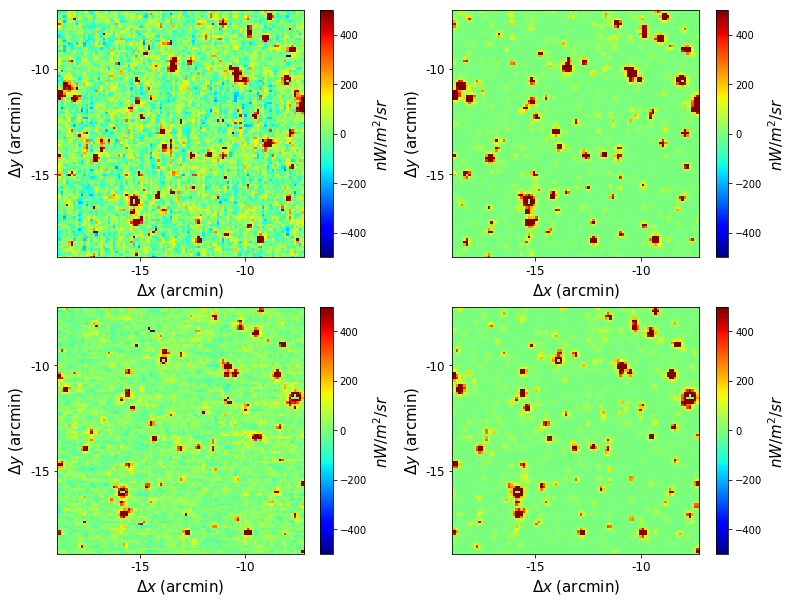

In [3]:
fig, ax = plt.subplots(2, 2, figsize = (13,10))

pixticks1 = np.linspace(0,511.5,13)
pixtick_labels1 = ['-60', '-55', '-50', '-45', '-40', '-35', 
                  '-30', '-25', '-20', '-15', '-10', '-5', '0']

ifield = 8
for inst in [1,2]:
    mask_inst, cbmap, psmap\
    = load_processed_images(data_maps, [(inst,ifield,'mask_inst'),
                                       (inst,ifield,'cbmap'),
                                       (inst,ifield,'psmap')],
                           rotate_TM2=True)
    axi = ax[inst-1][0]
    p = imageclip(cbmap*mask_inst, vmin=-500, vmax=500, ax=axi, return_objects=True)
    p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
    axi.set_xticks(pixticks1)
    axi.set_xticklabels(pixtick_labels1, fontsize=12)
    axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
    axi.set_yticks(pixticks1)
    axi.set_yticklabels(pixtick_labels1, fontsize=12)
    axi.set_xlim([350,450])
    axi.set_ylim([350,450])
    axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

    axi = ax[inst-1][1]
    p = imageclip(psmap*mask_inst, vmin=-500, vmax=500, ax=axi, return_objects=True)
    p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
    axi.set_xticks(pixticks1)
    axi.set_xticklabels(pixtick_labels1, fontsize=12)
    axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
    axi.set_yticks(pixticks1)
    axi.set_yticklabels(pixtick_labels1, fontsize=12)
    axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
    axi.set_xlim([350,450])
    axi.set_ylim([350,450])
# plt.savefig('plots/paperfig/srcmap.png', dpi = 200, bbox_inches='tight')

# stacking

### stacking maps

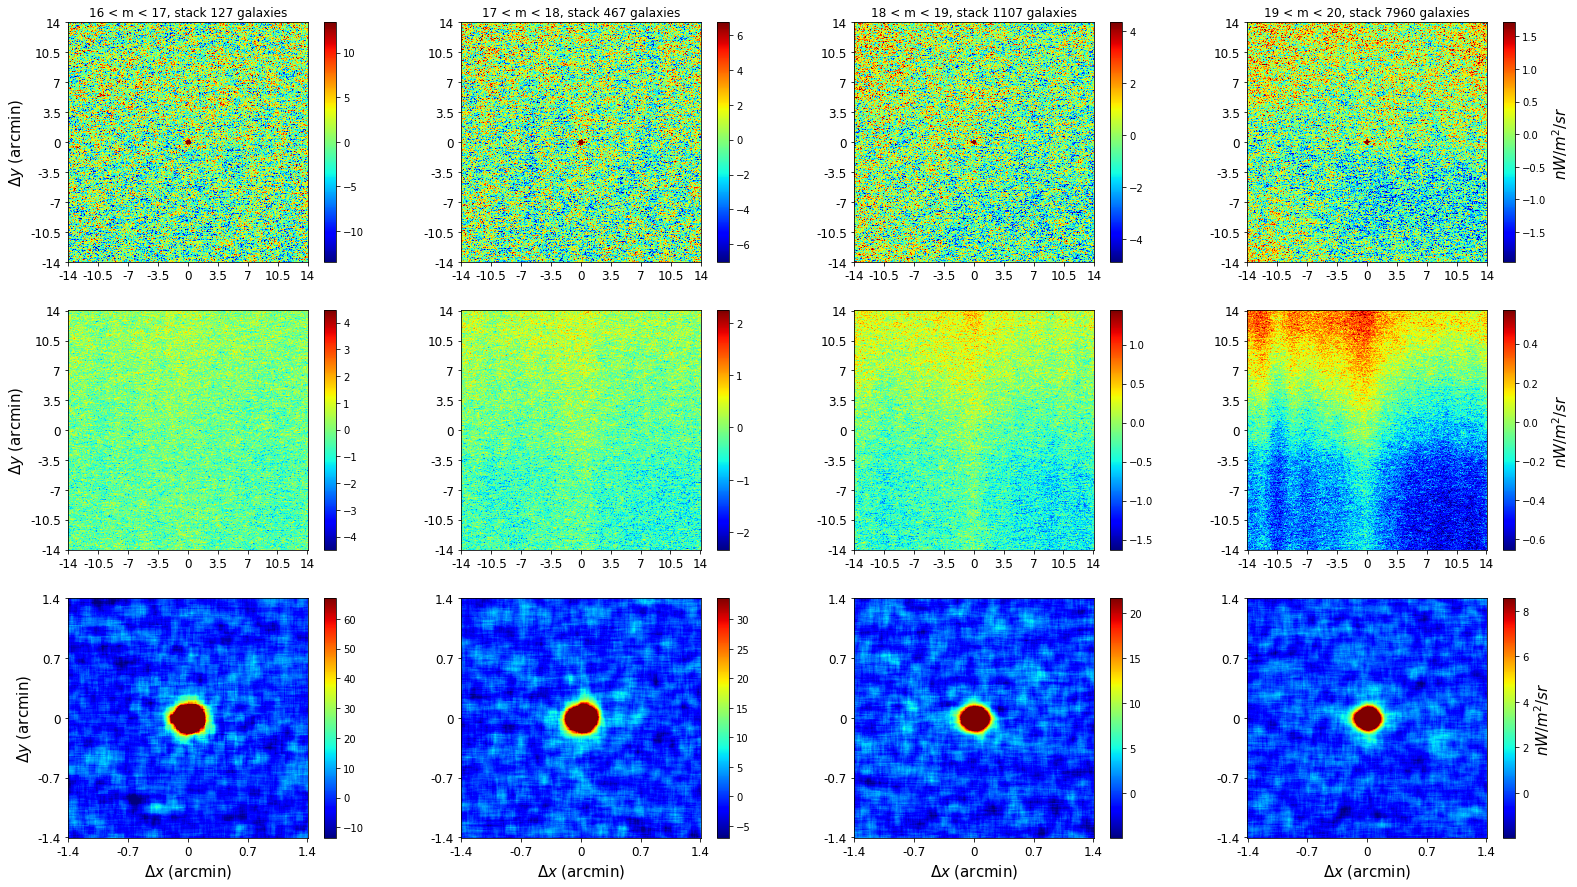

In [4]:
from stack import *

pixticks = np.linspace(0,2400,9)
pixtick_labels = ['-14', '-10.5', '-7', '-3.5', '0', '3.5', '7', '10.5', '14']

for ifield in [4,5,6,7,8]:
    for inst in [1,2]:
        plt.close()
        fig, ax = plt.subplots(3, 4, figsize = (27,15))
        for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
            stackdat = stacking(inst, ifield, m_min, m_max, load_from_file=True).stackdat

            axi = ax[0][im]
            stackmap = stackdat['cbmapstack']
            if inst==2:
                stackmap = np.rot90(stackmap, k=3)
            p = imageclip(stackmap, ax=axi, return_objects=True)
            if im==3:
                p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
            axi.set_xticks(pixticks)
            axi.set_xticklabels(pixtick_labels, fontsize=12)
            axi.set_yticks(pixticks)
            axi.set_yticklabels(pixtick_labels, fontsize=12)
            if im==0:
                axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
            axi.set_title('%d < m < %d, stack %d galaxies'%(m_min, m_max, stackdat['Nsrc']))
            vmin, vmax = p['vmin'], p['vmax']

            axi = ax[1][im]
            stackmap = stackdat['cbmapstackBG']
            if inst==2:
                stackmap = np.rot90(stackmap, k=3)

            p = imageclip(stackmap, ax=axi, 
                          vmin=vmin/3, vmax=vmax/3, return_objects=True)
            if im==3:
                p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
            axi.set_xticks(pixticks/10)
            axi.set_xticklabels(pixtick_labels, fontsize=12)
            axi.set_yticks(pixticks/10)
            axi.set_yticklabels(pixtick_labels, fontsize=12)
            if im==0:
                axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

            axi = ax[2][im]
            stackmap = stackdat['cbmapstack'][1080:1321, 1080:1321]
            if inst==2:
                stackmap = np.rot90(stackmap, k=3)
            pixticks1 = np.linspace(0,240,5)
            pixtick_labels1 = ['-1.4', '-0.7', '0', '0.7', '1.4']
            p = imageclip(stackmap, ax=axi, return_objects=True, vmin=vmin, vmax=vmax*5)
            if im==3:
                p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
            axi.set_xticks(pixticks1)
            axi.set_xticklabels(pixtick_labels1, fontsize=12)
            axi.set_yticks(pixticks1)
            axi.set_yticklabels(pixtick_labels1, fontsize=12)
            axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
            if im==0:
                axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

        plt.savefig('plots/paperfig/stackmaps_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
                    dpi = 200, bbox_inches='tight')

### stacking & excess profile

#### individual fields

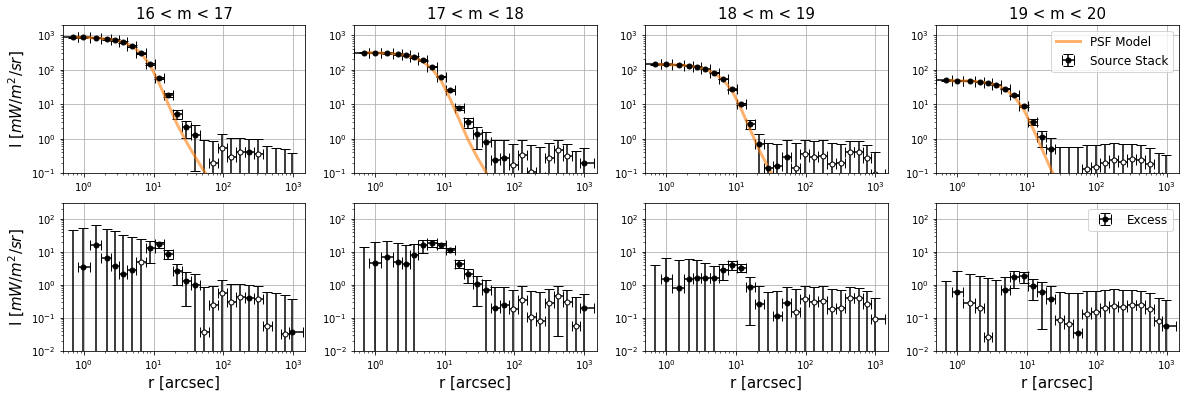

In [9]:
from stack import *

for ifield in [4,5,6,7,8]:
    for inst in [1,2]:
        plt.close()
        fig, ax = plt.subplots(2, 4, figsize = (20,6))
        for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
            stackdat = stacking(inst, ifield, m_min, m_max, load_from_file=True, BGsub=False).stackdat
            plot_err_log(stackdat['rbins'], 
                         stackdat['profcb'],
                         np.sqrt(np.diag(stackdat['cov']['profcb'])),
                         ax=ax[0][im], color='k',label='Source Stack')
            ax[0][im].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                          'C1', alpha=0.6, lw=3, label='PSF Model')
#             plot_err_log(stackdat['rbins']*1.01, 
#                          stackdat['BG']['profcb'],
#                          np.sqrt(np.diag(stackdat['BGcov']['profcb'])),
#                          ax=ax[0][im], color='C0', label='Background Stack')
            ax[0][im].set_ylim([1e-1,2e3])
            ax[0][im].set_xlim([5e-1,1.5e3])
            ax[0][im].grid()    
            ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)

            plot_err_log(stackdat['rbins'], 
                         stackdat['ex']['profcb'],
                         np.sqrt(np.diag(stackdat['excov']['profcb'])),
                         ax=ax[1][im], color='k',label='Excess')
            ax[1][im].set_ylim([1e-2,3e2])
            ax[1][im].set_xlim([5e-1,1.5e3])
            ax[1][im].grid()    
            ax[1][im].set_xlabel('r [arcsec]', fontsize=15)

        ax[0][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
        ax[1][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
        ax[0][-1].legend(fontsize=12)
        ax[1][-1].legend(fontsize=12)

        plt.savefig('plots/paperfig/profile_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
                    dpi = 200, bbox_inches='tight')

#### field-averaged

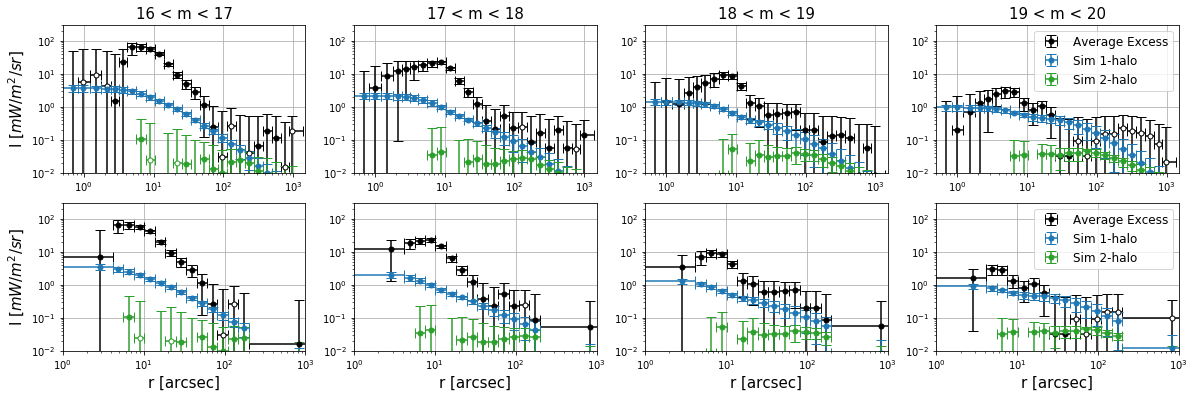

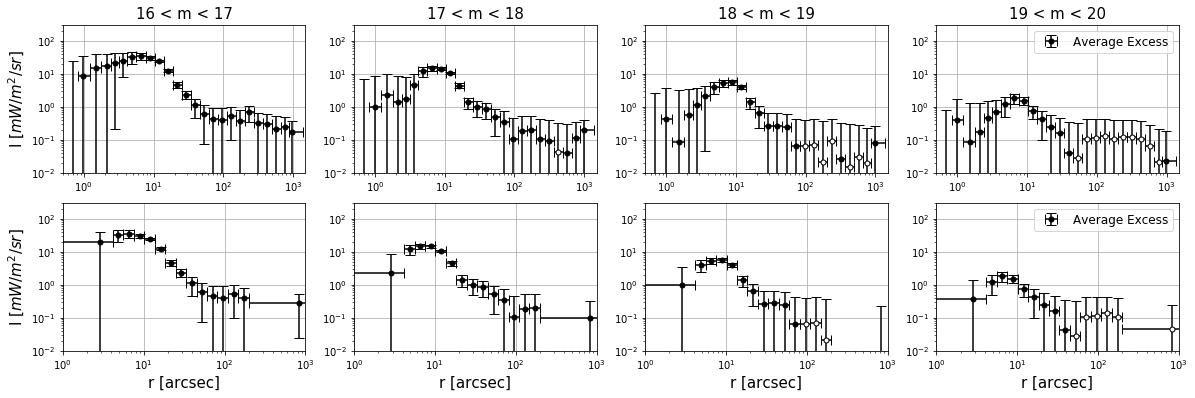

In [127]:
from stack import *
# from micecat import *
for inst in [1,2]:
    fig, ax = plt.subplots(2, 4, figsize = (20,6))
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        profd_arr, profd_err = 0, 0
        profdsub_arr, profdsub_err = 0, 0
        for ifield in [4,5,6,7,8]:
            stackdat = stacking(inst, ifield, m_min, m_max, 
                                load_from_file=True,BGsub=False).stackdat
            profd_arri = stackdat['ex']['profcb']
            profd_erri = np.sqrt(np.diag(stackdat['excov']['profcb']))
            profd_arr += profd_arri / profd_erri**2
            profd_err += 1 / profd_erri**2
            profdsub_arri = stackdat['ex']['profcbsub']
            profdsub_erri = np.sqrt(np.diag(stackdat['excov']['profcbsub']))
            profdsub_arr += profdsub_arri / profdsub_erri**2
            profdsub_err += 1 / profdsub_erri**2

        profd_arr /= profd_err
        profd_err = np.sqrt(1 / profd_err)
        profdsub_arr /= profdsub_err
        profdsub_err = np.sqrt(1 / profdsub_err)

        plot_err_log(stackdat['rbins'], 
                 profd_arr,profd_err,
                 ax=ax[0][im], color='k',label='Average Excess')
        plot_err_log(stackdat['rsubbins'], 
                 profdsub_arr,profdsub_err,
                 xedges = stackdat['rsubbinedges'],
                 ax=ax[1][im], color='k',label='Average Excess')
        
        if inst==1:
            _, mc_avg, mc_std, _ = get_micecat_sim_1h(inst, im, sub=False)
            _, mc_avg_sub, mc_std_sub, _ = get_micecat_sim_1h(inst, im, sub=True)
            plot_err_log(stackdat['rbins'], 
                     mc_avg, mc_std,
                     ax=ax[0][im], color='C0',label='Sim 1-halo')
            plot_err_log(stackdat['rsubbins'], 
                     mc_avg_sub, mc_std_sub,
                     xedges = stackdat['rsubbinedges'],
                     ax=ax[1][im], color='C0',label='Sim 1-halo')

            _, mc_avg, mc_std, _ = get_micecat_sim_cen(inst, im, filt_order=2, sub=False)
            _, mc_avg_sub, mc_std_sub, _ = get_micecat_sim_cen(inst, im, filt_order=2, sub=True)
            plot_err_log(stackdat['rbins'], 
                     mc_avg, mc_std,
                     ax=ax[0][im], color='C2',label='Sim 2-halo')
            plot_err_log(stackdat['rsubbins'], 
                     mc_avg_sub, mc_std_sub,
                     xedges = stackdat['rsubbinedges'],
                     ax=ax[1][im], color='C2',label='Sim 2-halo')

        ax[0][im].set_ylim([1e-2,3e2])
        ax[0][im].set_xlim([5e-1,1.5e3])
        ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
        ax[0][im].grid()    
        ax[1][im].set_ylim([1e-2,3e2])
        ax[1][im].set_xlim([1e0,1e3])
        ax[1][im].grid()    
        ax[1][im].set_xlabel('r [arcsec]', fontsize=15)

    ax[0][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
    ax[1][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
    ax[0][-1].legend(fontsize=12)
    ax[1][-1].legend(fontsize=12)

    plt.savefig('plots/paperfig/profile_TM%d.png'%(inst),
                dpi = 200, bbox_inches='tight')

## Stacked Source Distribution

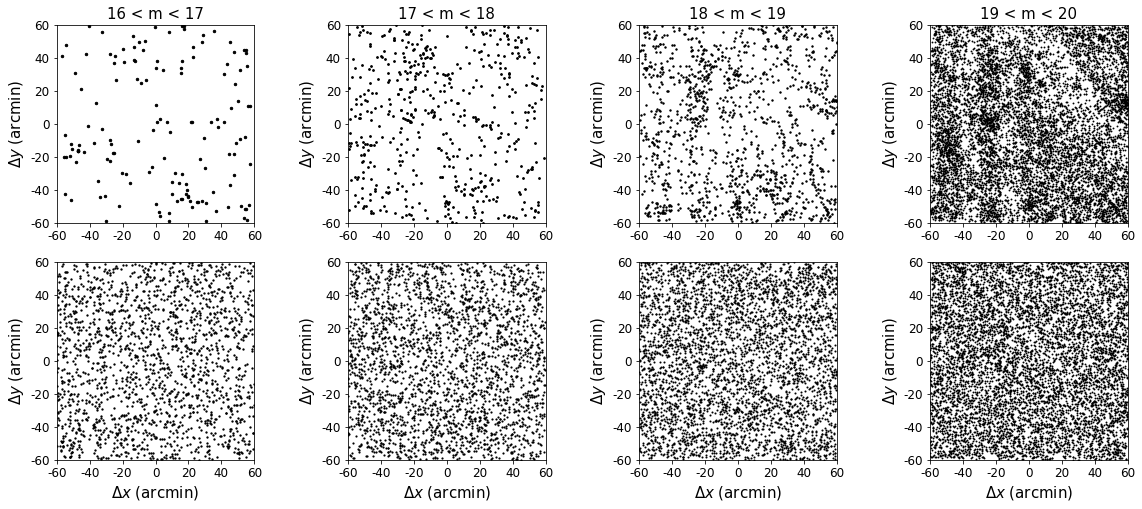

In [8]:
from stack_ancillary import *

pixticks = np.linspace(0,1023,7)
pixtick_labels = ['-60', '-40', '-20', '0', '20', '40', '60']

for ifield in [4,5,6,7,8]:
    plt.close()
    fig, ax = plt.subplots(2, 4, figsize = (20,8))
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        srcdat = ps_src_select(1, ifield, m_min, m_max, 
                       [np.ones((1024,1024)), np.ones((1024,1024))], sample_type='all')
        xg, yg = srcdat['xg_arr'], srcdat['yg_arr']
        xs, ys = srcdat['xs_arr'], srcdat['ys_arr']
        
        ax[0][im].scatter(xg, yg, s=np.sqrt(5e3/len(xg)), c='k')
        ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
        ax[0][im].set_xlim([0,1023])
        ax[0][im].set_ylim([0,1023])
        ax[0][im].set_aspect('equal')   
        ax[0][im].set_xticks(pixticks)
        ax[0][im].set_xticklabels(pixtick_labels, fontsize=12)
        ax[0][im].set_yticks(pixticks)
        ax[0][im].set_yticklabels(pixtick_labels, fontsize=12)
        ax[0][im].set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
        
        ax[1][im].scatter(xs, ys, s=np.sqrt(5e3/len(xs)), c='k')
        ax[1][im].set_xlim([0,1023])
        ax[1][im].set_ylim([0,1023])
        ax[1][im].set_aspect('equal')   
        ax[1][im].set_xticks(pixticks)
        ax[1][im].set_xticklabels(pixtick_labels, fontsize=12)
        ax[1][im].set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        ax[1][im].set_yticks(pixticks)
        ax[1][im].set_yticklabels(pixtick_labels, fontsize=12)
        ax[1][im].set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
    
    plt.savefig('plots/paperfig/gal_scatter_%s.pdf'%(fieldnamedict[ifield]),
                dpi = 200, bbox_inches='tight')

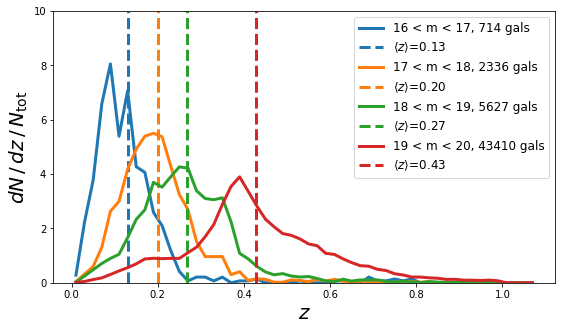

In [103]:
from astropy import units as u
from ciber_info import *

fig, ax = plt.subplots(1, 1, figsize = (9, 5))

dz = 0.02
binedges = np.arange(0,1.1,dz)
bins = (binedges[1:] + binedges[:-1]) / 2

htot = np.zeros([4, len(bins)],dtype=int)

for i,ifield in enumerate([4,5,6,7,8]):
    field = fieldnamedict[ifield]
    fname = mypaths['PScatdat']+ field + '.csv'
    df = pd.read_csv(fname)
    
    inst=1
    for im in range(4):
        m_min = im + 16
        m_max = im + 17
        dfi = df.loc[(df['sdssClass']==3) \
                    & (df['x'+str(inst)]>-0.5) & (df['x'+str(inst)]<1023.5)\
                    & (df['y'+str(inst)]>-0.5) & (df['y'+str(inst)]<1023.5)\
                    & (df['x'+str(inst)]>-0.5) & (df['x'+str(inst)]<1023.5)\
                    & (df['I_comb']>=m_min) & (df['I_comb']<m_max)]
        Nall = len(dfi)
        dfi = dfi.loc[dfi['Photz']>0]
        f = len(dfi)/Nall

        z = np.array(dfi['Photz'])
        ra = np.array(dfi['ra'])
        dec = np.array(dfi['dec'])

        meanz = np.mean(z)
        medianz = np.median(z)
        h,_ = np.histogram(z, bins=binedges)
        htot[im,:] = htot[im,:] + h
        
for im in range(4):
    m_min = im + 16
    m_max = im + 17
    meanz=np.sum(htot[im,:]*bins)/np.sum(htot[im,:])
    ax.plot(bins, htot[im,:]/np.sum(htot[im,:])/dz, lw=3,  c='C'+str(im),
              label='%d < m < %d'%(m_min,m_max) + ', %d gals'%np.sum(htot[im,:]))
    ax.axvline(meanz,c='C'+str(im),ls='--', lw=3, label=r'$\left< z \right>$=%.2f'%meanz)
ax.set_xlabel('$z$', fontsize=20)
ax.set_ylabel(r'$dN\,/\,dz\,/\,N_{\rm tot}$', fontsize=20)
ax.legend(fontsize=12)
ax.set_ylim([0,10])
plt.savefig('plots/z_kernel.pdf', dpi = 200, bbox_inches='tight')

# Plot for MZ

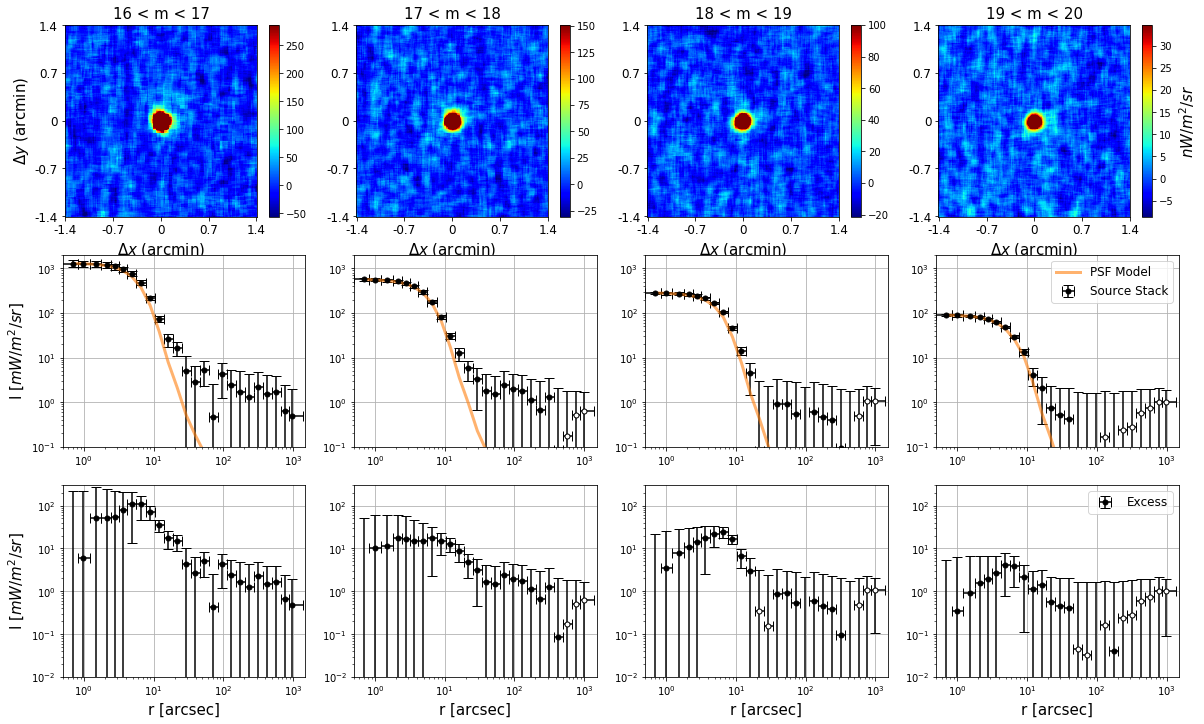

In [149]:
from stack import *

inst = 1
ifield = 6

fig, ax = plt.subplots(3, 4, figsize = (20,12))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    stackdat = stacking(inst, ifield, m_min, m_max, load_from_file=True, BGsub=False).stackdat
    plot_err_log(stackdat['rbins'], 
                 stackdat['profcb'],
                 np.sqrt(np.diag(stackdat['cov']['profcb'])),
                 ax=ax[1][im], color='k',label='Source Stack')
    ax[1][im].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                  'C1', alpha=0.6, lw=3, label='PSF Model')
    ax[1][im].set_ylim([1e-1,2e3])
    ax[1][im].set_xlim([5e-1,1.5e3])
    ax[1][im].grid()    

    plot_err_log(stackdat['rbins'], 
                 stackdat['ex']['profcb'],
                 np.sqrt(np.diag(stackdat['excov']['profcb'])),
                 ax=ax[2][im], color='k',label='Excess')
    ax[2][im].set_ylim([1e-2,3e2])
    ax[2][im].set_xlim([5e-1,1.5e3])
    ax[2][im].grid()    
    ax[2][im].set_xlabel('r [arcsec]', fontsize=15)

    axi = ax[0][im]
    p = imageclip(stackdat['cbmapstack'], ax=axi, return_objects=True)
    p['cbar'].remove()
    vmin, vmax = p['vmin'], p['vmax']
    stackmap = stackdat['cbmapstack'][1080:1321, 1080:1321]
    pixticks1 = np.linspace(0,240,5)
    pixtick_labels1 = ['-1.4', '-0.7', '0', '0.7', '1.4']
    p = imageclip(stackmap, ax=axi, return_objects=True, vmin=vmin, vmax=vmax*5)
    if im==3:
        p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
    axi.set_xticks(pixticks1)
    axi.set_xticklabels(pixtick_labels1, fontsize=12)
    axi.set_yticks(pixticks1)
    axi.set_yticklabels(pixtick_labels1, fontsize=12)
    axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
    if im==0:
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
    axi.set_title('%d < m < %d'%(m_min, m_max), fontsize=15)

ax[1][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
ax[2][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
ax[1][-1].legend(fontsize=12)
ax[2][-1].legend(fontsize=12)

plt.savefig('/Users/sers/ytcheng/ciber/doc/MZ_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
            dpi = 200, bbox_inches='tight')